In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('./names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi= {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    block_size = 3
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and add

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte , Yte = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
n_embd = 10 # the dimensionality of the character embdding vectors
n_hidden = 200 # the number of hidden layer in the hidden layer in MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                              generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.01
b2 = torch.randn(vocab_size,                            generator=g) * 0 

# scale and shift in batch normlizition factors
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

paramaters = [C, W1, W2, b2,bngain, bnbias]
print(sum(p.nelement() for p in paramaters)) # number of paramaters
for p in paramaters:
    p.requires_grad = True

12097


In [8]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # Forward pass
    emb= C[Xb] # embed the characters into vectors 
    embcat = emb.view(emb.shape[0], -1) # concatinate the vectors
   
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    
    # Batch normliziation layer
    # ------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi= hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # this bias is the bn bias and this in charge of biasing of the distribution
    
    # running mean update
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------------
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in paramaters:
        p.grad = None
    loss.backward()

    # Update paramaters
    lr = 0.1 if i < 100_000 else 0.01 

    for p in paramaters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


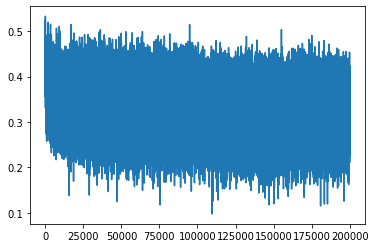

In [10]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # this decorator diables the gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb= C[x] # (N , block_size , n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N , block_size * n_embd)
    hpreact = embcat @ W1# + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N * vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0674145221710205
val 2.1056838035583496
